<center>
<div class="h1">Info 114: Introduction to Data Science</div>
<div class="h1">Homework 3: from VI-ME-BA-BAR to POM</div>
</center>

# Part 2: Data Analysis
We have now 4 datasets:
- one with only 2 features (<b>R</b>edness and <b>E</b>longation) called <b>RE_data.csv</b>
- one with only 21 features (<b>C</b>olor and <b>S</b>hape features) called <b>CS_data.csv</b>
- one with 14580 features (all pixels of 81x69x3 <b>raw</b> images) called <b>RAW_data.csv</b>
- one with 3072 features (all pixels of 32x32x3 <b>crop</b>ped images) called <b>CROP_data.csv</b>.

We will compare the performances of various classifiers on those 4 datasets. Thus, we are going to start doing "real" POM: Probability, Optimization, and Modeling. We will proceed in a "greedy" way, eliminating some non promising avenues as we go, and not revisiting them for the moment:

1. Which dataset version should we keep? Should we or not scale variables (using variable standardization)?
2. Which learning machine of a standard toolkit (scikit-learn) is most promising?

## Setup

In [1]:
# Load general libraries
import os, re
from glob import glob as ls
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import qgrid
import seaborn as sns; sns.set()
from PIL import Image
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import our own code
code_dir = './code'
from sys import path; path.append(code_dir); 
from utilities import *

## Step 1: Select data representation
Which dataset version should we keep? Should we do or not a variable standardization?

1. List all the datasets in directory `data_dir = "./mini-dataset/"` and call the resulting list `data_list`. Hint: use the above shorthand for `glob.glob`.

In [3]:
### BEGIN SOLUTION
data_dir = './mini-dataset/'
data_list = ls(data_dir + '*_data.csv')
data_list
### END SOLUTION

['./mini-dataset/RE_data.csv',
 './mini-dataset/CROP_data.csv',
 './mini-dataset/CS_data.csv',
 './mini-dataset/RAW_data.csv']

2. Call `check_datasets(data_list)` to view some statistics on the datasets. As usual, If you want to check how this code is written, type `check_datasets??``.

In [4]:
### BEGIN SOLUTION
check_datasets(data_list)
### END SOLUTION

,Dataset,num. examples,num. features,num. apples,num. bananas
0,RE,491,3,333,158
1,CROP,491,3073,333,158
2,CS,491,22,333,158
3,RAW,491,14581,333,158


### Question 1: Load, visualize, and preprocess data with `panda`

In previous classes we learned to use **arrays** (from the `numpy` library) to manipulate raw tables of data.
It is time to learn about **data frames** (from the `panda` library). There are like arrays,
but can be enriched with row and column names; as above; as in a spreadsheet.

Data frames make tables easier to read and less error prone to access (hmm, were the number of apples stored in column 4 or 5?). More importantly: *everything you would usually do with a spreadsheet, you can do with data frames*: visualization, statistics, etc. But now you have the choice to do it interactively, or to **program it**. And thereby, **automatize** repeated operations and **document** your processes. And you can do fancy **database operations** too.

You should learn more about them. Oh, and `panda` is just one of the favorite implementation of data frames; you will find them in many other languages, notably `R`.

1. In an editor, open `RL_data.csv` or another of the dataset files to see how it looks like. The dataset is formatted in the CSV format (Comma Separated Values). The examples are in lines and the features are separated by commas. The first line is the header. You may also make a call to a UNIX command to view just the first few lines of the file.

In [5]:
### BEGIN SOLUTION
!head ./mini-dataset/RE_data.csv
### END SOLUTION

redness,elongation,fruit
8.429611650485437,1.4032012759326986,1.0
42.89607843137255,1.7032009898154288,1.0
56.354066985645936,1.5508105645577395,1.0
-10.528846153846153,1.7773426521360935,1.0
-17.131386861313867,2.047174441534352,1.0
36.041666666666664,1.4139561143744013,1.0
34.744932432432435,1.2379057682280559,1.0
1.8179190751445087,1.0839275628229141,1.0
3.34106529209622,1.0972000640347488,1.0


2. Load `RL_data.csv` as a pandas dataframe called `df`. Show the first few lines using the method `head`.

In [6]:
### BEGIN SOLUTION
df = pd.read_csv(os.path.join(data_dir, 'RE_data.csv'))
df.head()
### END SOLUTIONb

,redness,elongation,fruit
0,8.429612,1.403201,1.0
1,42.896078,1.703201,1.0
2,56.354067,1.550811,1.0
3,-10.528846,1.777343,1.0
4,-17.131387,2.047174,1.0


3. Use `qgrid.show_grid` to interactively view the whole data frame, sort the examples by redness, and those with elongation between 2.5 and 3.

In [8]:
### BEGIN SOLUTION
qgrid.show_grid(df)
### END SOLUTION

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

4. Compute simple statistics using the method `describe`.

In [12]:
### BEGIN SOLUTION
df.describe()
### END SOLUTION

,redness,elongation,fruit
count,491.000000,491.000000,491.000000
mean,17.863426,1.468878,0.356415
std,21.805386,0.521078,0.935280
min,-47.045455,1.000000,-1.000000
25%,3.895620,1.161664,-1.000000
50%,14.380952,1.300111,1.000000
75%,33.848108,1.598103,1.000000
max,100.364865,5.231697,1.000000


5. Imagine that you do now know how to make a heat map (or you do not remember). Use your favorite search engine with the keywords: `pandas`, `heatmap`. I found <a href="https://stackoverflow.com/questions/12286607/making-heatmap-from-pandas-dataframe">this post</a>, for instance. Now find a way of showing the dataset as a heat map.

In [14]:
### BEGIN SOLUTION
df.style.background_gradient(cmap='Blues')
# This way of creating heat maps is pretty cool, we do not need to standardize features
### END SOLUTION

,redness,elongation,fruit
0,8.42961,1.4032,1
1,42.8961,1.7032,1


6. You remember that it is often useful to `standardize` the columns of the data table to put them all on the same scale. Change your data frame `df` to `df_scaled` by subtracting the mean of all columns and dividing by the standard deviation. Perform again the steps of questions 2., 3., 4.. What do you notice?<br>
    **Hints**:
    - search for the methods that compute respectively the mean and standard deviation;
    - you can do arithmetic on data frames like you did on arrays;

In [15]:
### BEGIN SOLUTION
df_scaled = (df-df.mean())/df.std()
df_scaled.head()
### END SOLUTION

,redness,elongation,fruit
0,-0.432637,-0.126039,0.688119
1,1.148003,0.449690,0.688119
2,1.765190,0.157238,0.688119
3,-1.302076,0.591975,0.688119
4,-1.604870,1.109809,0.688119


BEGIN SOLUTION
Oops, the last column changed, the target values are no longer +-1
END SOLUTION

7. Write a function that takes as input a data frame `df` containing a dataset and returns a dataframe `df_scaled` with the columns standardized <b>EXCEPT THE TARGET VALUES</b> of the last column. Use this template for your code:
    

In [16]:
def standardize_df(df):
    '''Standardize all the columns except the last one (target values).'''
    ### BEGIN SOLUTION
    df_scaled = (df-df.mean())/df.std()
    df_scaled.iloc[:, -1] = df.iloc[:, -1]
    ### END SOLUTION
    return df_scaled

8. Test your function with the same dataframe as in the previous questions and use the methods `head` and `describe` to verify that all the columns are standardized, except the last one. Copy the function in `my_utilities.py`.

In [19]:
### BEGIN SOLUTION
df_scaled = standardize_df(df)
df_scaled.head()
### END SOLUTION

,redness,elongation,fruit
0,-0.432637,-0.126039,1.0
1,1.148003,0.449690,1.0
2,1.765190,0.157238,1.0
3,-1.302076,0.591975,1.0
4,-1.604870,1.109809,1.0


In [20]:
### BEGIN SOLUTION
df_scaled.describe()
### END SOLUTION

,redness,elongation,fruit
count,4.910000e+02,4.910000e+02,491.000000
mean,-1.447134e-16,-7.380383e-16,0.356415
std,1.000000e+00,1.000000e+00,0.935280
min,-2.976736e+00,-8.998221e-01,-1.000000
25%,-6.405668e-01,-5.895726e-01,-1.000000
50%,-1.597070e-01,-3.238798e-01,1.000000
75%,7.330612e-01,2.479972e-01,1.000000
max,3.783535e+00,7.221221e+00,1.000000


Notice that the mean is not exactly 0, this depends on the machine precision.

In [44]:
# Check that the size of the data frame and its last column were not changed:
assert len(df_scaled.index) == 491
assert list(df_scaled.columns) == ['redness', 'elongation', 'fruit']
assert (df_scaled['fruit'] == df['fruit']).all()

In [45]:
# Check that the value are indeed standardized
assert abs( df_scaled['redness'].mean()    ) < 0.01
assert abs( df_scaled['redness'].std() - 1 ) < 0.01
assert abs( df_scaled['elongation'].mean()    ) < 0.01
assert abs( df_scaled['elongation'].std() - 1 ) < 0.01

Notice that with the default heat maps, colors do not change after standardization:

In [51]:
df_scaled.style.background_gradient(cmap='Blues')

,redness,elongation,fruit
0,-0.432637,-0.126039,1
1,1.148,0.44969,1


### Question 2: Select the best representation
We are now going to loop over all datasets and compare the performance of our baseline method (one nearest neighbor classifier) with and without variable scaling. 

1.  Import the scikit-learn (`sklearn`) one nearest neighbor classifier and name it `sklearn_model`. Also import the `balanced_accuracy_score` and name it sklearn_metric.

In [52]:
### BEGIN SOLUTION
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score as sklearn_metric
sklearn_model = KNeighborsClassifier(n_neighbors=1)
### END SOLUTION

2.  Call `df_cross_validate(df, sklearn_model, sklearn_metric)` and collect the results, then print the training and test performance and their error bars.<br>
    **Tip:** look at the bottom of the code using `df_cross_validate??` to get an idea on how to print the results. 

In [53]:
### BEGIN SOLUTION
p_tr, s_tr, p_te, s_te = df_cross_validate(df, sklearn_model, sklearn_metric)
metric_name = sklearn_metric.__name__.upper()
print("AVERAGE TRAINING {0:s} +- STD: {1:.2f} +- {2:.2f}".format(metric_name, p_tr, s_tr))
print("AVERAGE TEST {0:s} +- STD: {1:.2f} +- {2:.2f}".format(metric_name, p_te, s_te))
### END SOLUTION

AVERAGE TRAINING BALANCED_ACCURACY_SCORE +- STD: 1.00 +- 0.00
AVERAGE TEST BALANCED_ACCURACY_SCORE +- STD: 0.64 +- 0.03


3. Create:
    - a list containing all the dataset dataframes and call it `all_data_df`
    - a list containg all the dataset names and call it `data_name`. 

    Then run the function `systematic_data_experiment(data_name, all_scaled_data_df, sklearn_model, sklearn_metric)` and display the results.

In [54]:
### BEGIN SOLUTION
data_name = [os.path.basename(f)[:-9] for f in data_list]
all_data_df = [pd.read_csv(file) for file in data_list]
print('NO SCALING')
result_noscaling = systematic_data_experiment(data_name, all_data_df, sklearn_model, sklearn_metric)
result_noscaling.style.background_gradient(cmap='Blues')
### END SOLUTION

NO SCALING
KNEIGHBORSCLASSIFIER


,perf_tr,std_tr,perf_te,std_te
RE,1,0,0.642204,0.0300118
CROP,1,0,0.747946,0.0334551
CS,1,0,0.546047,0.0241897
RAW,1,0,0.571887,0.0282349


4.  Create:
    - a list containing all the SCALED datasets (variables standardized) and call it `all_scaled_data_df`

    Then run again `systematic_data_experiment` on `all_scaled_data_df` and display the results.

In [55]:
### BEGIN SOLUTION
all_scaled_data_df = [standardize_df(df) for df in all_data_df]
print('WITH SCALING')
result_scaling = systematic_data_experiment(data_name, all_scaled_data_df, sklearn_model, sklearn_metric)
result_scaling.style.background_gradient(cmap='Blues')
### END SOLUTION

WITH SCALING
KNEIGHBORSCLASSIFIER


,perf_tr,std_tr,perf_te,std_te
RE,1,0,0.61544,0.0204092
CROP,1,0,0.71234,0.0244602
CS,1,0,0.792288,0.0221641
RAW,1,0,0.554434,0.0375432


5.  Fuse the results of the two previous question by creating a dataframe called `joint_results`.
    Assign `result_scaling.perf_te` to a column called `'SCALED'` and `result_noscaling.perf_te` to a column called `'NOT SCALED'`.
    Display the results.

In [56]:
### BEGIN SOLUTION
joint_results = pd.DataFrame()
joint_results['SCALED'] = result_scaling.perf_te
joint_results['NOT SCALED'] = result_noscaling.perf_te
joint_results
### END SOLUTION

,SCALED,NOT SCALED
RE,0.615440,0.642204
CROP,0.712340,0.747946
CS,0.792288,0.546047
RAW,0.554434,0.571887


6.  Visualize `joint_results` with a histogram. Does variable scaling always help?

Text(0, 0.5, 'balanced_accuracy_score')

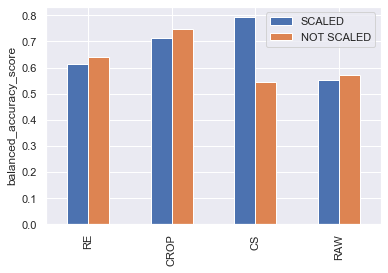

In [57]:
### BEGIN SOLUTION
# The best representation is CS SCALED
joint_results.plot.bar()
plt.ylabel(sklearn_metric.__name__)
### END SOLUTION

## Step 2: Indentify the best model
We are now ready to perform systematic experiments on various models. We will use the methods proposed in the variable `classifiers` of <a href="https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html">these scikit-learn examples</a>, compare classifier performances on the dataset `CS_SCALED`:

1.  Create a variable `data_df` and assign to it the data frame of the scaled version of the CS dataset.

In [58]:
### BEGIN SOLUTION
data_df = all_scaled_data_df[2]
### END SOLUTION

2.  Create a variable `model_name` and a variable `model_list` containing the list of model names and the list of models (classifiers) from the [the scikit-learn examples](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html") we pointed you to.

In [59]:
### BEGIN SOLUTION
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

model_name = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
model_list = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=10),
    RandomForestClassifier(max_depth=10, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]
### END SOLUTION

3.  Call `systematic_model_experiment(data_df, model_name, model_list, sklearn_metric)` and display the results. 

In [60]:
### BEGIN SOLUTION
compar_results = systematic_model_experiment(data_df, model_name, model_list, sklearn_metric)
compar_results.style.background_gradient(cmap='Blues')
### END SOLUTION

,perf_tr,std_tr,perf_te,std_te
Nearest Neighbors,0.89011,0.0181331,0.814818,0.0253943
Linear SVM,0.760862,0.0127473,0.74873,0.0134185
RBF SVM,0.999367,0.00189873,0.579652,0.0191934
Gaussian Process,0.85053,0.0323953,0.796938,0.0118428
Decision Tree,0.988097,0.0170948,0.748132,0.0246834
Random Forest,0.9824,0.00653863,0.785871,0.0248282
Neural Net,0.852333,0.0244173,0.788096,0.0148244
AdaBoost,0.999398,0.00180723,0.782627,0.0242981
Naive Bayes,0.759021,0.0176058,0.748764,0.0202091
QDA,0.832309,0.0195283,0.779394,0.030938


4.  Which method performs best?<br>
    **Tip:*** Use [argmax](https://pandas.pydata.org/pandas-docs/version/0.19/generated/pandas.Series.argmax.html).

In [61]:
### BEGIN SOLUTION
compar_results.perf_te.argmax()
### END SOLUTION

'Nearest Neighbors'

5. **Overfitting and underfitting**. There may be two reasons why a model performs poorly. It could either be *overfitting* or *underfitting* data. If the test performance is bad but the training performance is good, the model is overfitting. If both are bad, the model is under-fitting. 
    1. Find which models have TEST performance UNDER THE MEDIAN test performance. 
    2. Of those, we will say that models with TRAINING performance UNDER THE MEDIAN training performance are under-fitted, while those with TRAINING performance OVER THE MEDIAN are over-fitted.

    Which models are over-fitted and which ones are under-fitted?

In [62]:
### BEGIN SOLUTION
analyze_model_experiments(compar_results)
### END SOLUTION

,perf_tr,std_tr,perf_te,std_te,Overfitted,Underfitted
Nearest Neighbors,0.89011,0.0181331,0.814818,0.0253943,False,False
Linear SVM,0.760862,0.0127473,0.74873,0.0134185,False,True
RBF SVM,0.999367,0.00189873,0.579652,0.0191934,True,False
Gaussian Process,0.85053,0.0323953,0.796938,0.0118428,False,False
Decision Tree,0.988097,0.0170948,0.748132,0.0246834,True,False
Random Forest,0.9824,0.00653863,0.785871,0.0248282,False,False
Neural Net,0.852333,0.0244173,0.788096,0.0148244,False,False
AdaBoost,0.999398,0.00180723,0.782627,0.0242981,False,False
Naive Bayes,0.759021,0.0176058,0.748764,0.0202091,False,True
QDA,0.832309,0.0195283,0.779394,0.030938,False,True


Text(0, 0.5, 'balanced_accuracy_score')

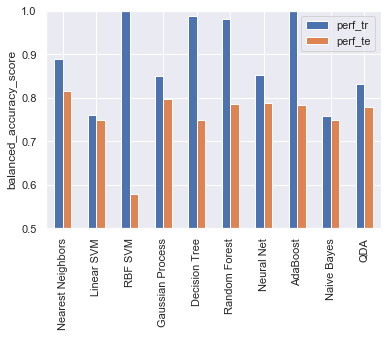

In [63]:
### BEGIN SOLUTION
compar_results[['perf_tr', 'perf_te']].plot.bar()
plt.ylim(0.5, 1)
plt.ylabel(sklearn_metric.__name__)
### END SOLUTION